## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
import scipy
from scipy.stats import linregress
sns.set(style='darkgrid')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [24]:
pd.__version__
np.__version__
matplotlib.__version__
sns.__version__
scipy.__version__


'0.24.2'

'1.16.2'

'3.0.3'

'0.9.0'

'1.2.1'

A helper function to help us create our databases and dataframes.

In [2]:
def dataframedb(csvfile, tablename, dbname, querystring):
    df = pd.read_csv(csvfile)
    df.to_sql(tablename, sql.connect(dbname), if_exists="replace")
    con = sql.connect(dbname)
    return pd.read_sql_query(querystring, con)

### Create databases and dataframes

In [3]:
# Federal Funds Dataframe, SQL
fftuple = ("FEDFUNDS.csv",
           "ff_table",
           "ff.db",
           'SELECT STRFTIME("%Y-%m", "DATE") AS FDate, FEDFUNDS FROM ff_table'
           )
ff_df = dataframedb(*fftuple)


In [4]:
# GDP Dataframe, SQL
gdptuple = ("A191RL1Q225SBEA.csv",
            "gdp_table",
            "gdp.db",
            'SELECT STRFTIME("%Y-%m", "DATE") AS FDate, GDP FROM gdp_table WHERE FDate >= "1954-07"'
            )
gdp_df = dataframedb(*gdptuple)


In [5]:
# SNP 500 Dataframe, SQL
snp_tuple = ("^GSPC.csv",
             "snp_table",
             "snp.db",
             'SELECT STRFTIME("%Y-%m", Date) AS FDate, MAX(Close) AS maxclose FROM snp_table GROUP BY FDate HAVING FDate >= "1954-07"'
             )
snp_df = dataframedb(*snp_tuple)
# SNP 500 % change month over month
snp_pc_df = pd.DataFrame({
    'FDate': snp_df['FDate'],
    'Percent Change': snp_df['maxclose'].pct_change() * 100
})
snp_pc_df.drop(snp_pc_df.index[0], inplace=True)

In [6]:
# Combine Dataframes
gdp_df.drop(gdp_df.index[0], inplace=True)
ff_df.drop(ff_df.index[0], inplace=True)
combined = pd.concat([snp_pc_df, gdp_df, ff_df], sort=False)
combined['FDate'] = pd.to_datetime(combined['FDate'], infer_datetime_format=True)
df_combined = combined.groupby("FDate", as_index=False).mean()
# Backfill GDP
df_combined['GDP'].bfill(limit=2, inplace=True)
df_combined.dropna(inplace=True)
#df_combined

### Plotting
Some initial line plots so we can see what each one of our datasets looks like at a glance, and a composition of the datasets.

Text(0, 0.5, 'Percent')

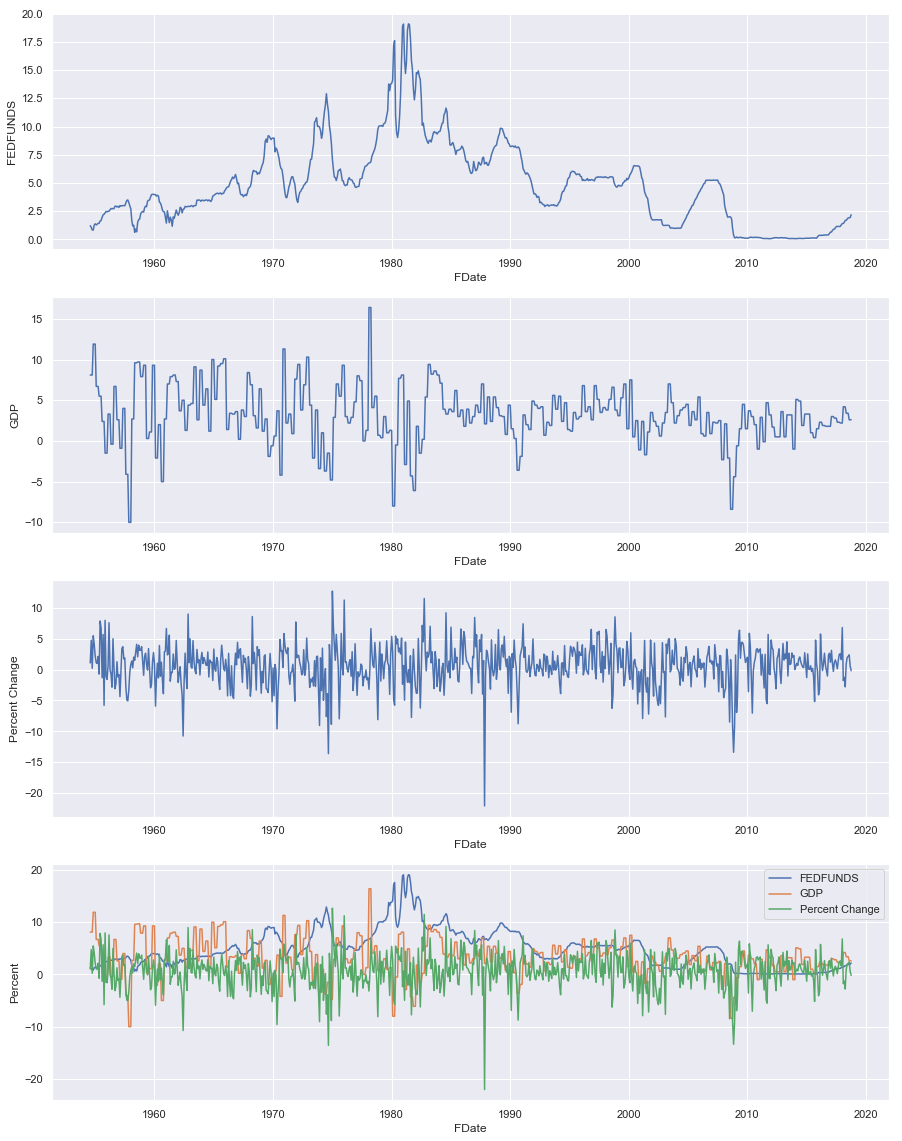

In [7]:
# Line Plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,20))
sns.lineplot(x='FDate', y='FEDFUNDS', data=df_combined, ax=ax1)
sns.lineplot(x='FDate', y='GDP', data=df_combined, ax=ax2)
sns.lineplot(x='FDate', y='Percent Change', data=df_combined, ax=ax3)
ff = sns.lineplot('FDate', 'FEDFUNDS', data=df_combined, ax=ax4),
gdp = sns.lineplot('FDate', 'GDP', data=df_combined, ax=ax4),
pc = sns.lineplot('FDate', 'Percent Change', data=df_combined, ax=ax4)
ax4.set_ylabel('Percent')
ax4.legend(['FEDFUNDS', 'GDP', 'Percent Change'])


### Linear Regression
Comparing the data via linear regression, attempting to discern relationships between FFR, stock market, and GDP.

LinregressResult(slope=-0.11793592819782386, intercept=5.195269691370895, rvalue=-0.11601603986279005, pvalue=0.0012506023015687216, stderr=0.03641013868996653)

LinregressResult(slope=-0.07360889221608681, intercept=4.873221530579812, rvalue=-0.06769582657753093, pvalue=0.060270686911410604, stderr=0.03912080684094117)

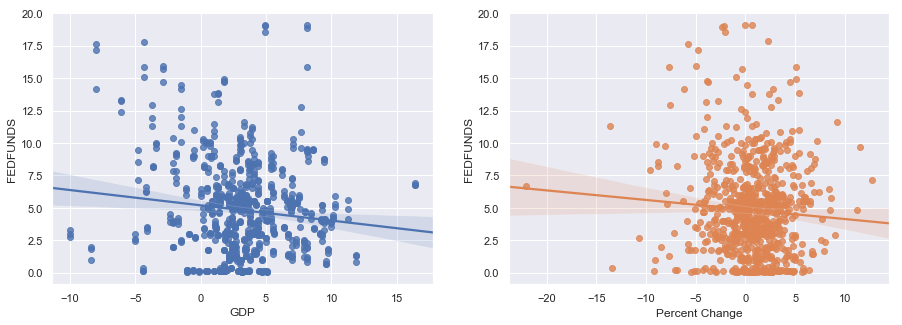

In [8]:
# Linear Regression Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined, ax=ax2)
# Linear Regression Data
x = df_combined['GDP']
y = df_combined['FEDFUNDS']
linregress(x,y)

x = df_combined['Percent Change']
y = df_combined['FEDFUNDS']
linregress(x,y)

### Fed Chairmen
Here we do a regression analysis on each fed chairman and the rate action vs S&P and GDP during their tenure.

#### Martin

LinregressResult(slope=-0.11451132141150538, intercept=4.049533728597546, rvalue=-0.27104205804597664, pvalue=0.00018264146360453542, stderr=0.029980165440854314)

LinregressResult(slope=-0.13441833075519447, intercept=3.6667662179524867, rvalue=-0.22377769831361433, pvalue=0.0021378654777528543, stderr=0.04315957001118524)

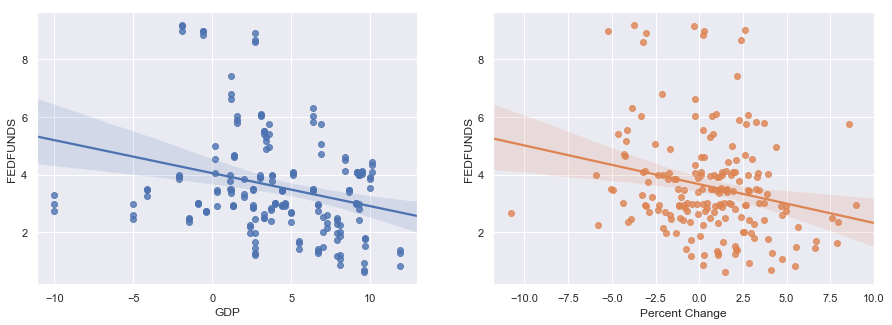

In [9]:
# Data per fed chairman
# Martin
df_combined_martin = df_combined[df_combined['FDate'] < '1970-02-01']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined_martin, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined_martin, ax=ax2)
x = df_combined_martin['GDP']
y = df_combined_martin['FEDFUNDS']
linregress(x, y)
x = df_combined_martin['Percent Change']
y = df_combined_martin['FEDFUNDS']
linregress(x, y)
#df_combined_martin

#### Burns

LinregressResult(slope=-0.33399861723061547, intercept=7.560997631291498, rvalue=-0.6373112783710404, pvalue=2.2406027753134974e-12, stderr=0.04143467283784597)

LinregressResult(slope=-0.21824971603569573, intercept=6.509502080569463, rvalue=-0.3865130067572531, pvalue=9.211522012034583e-05, stderr=0.0534308920873141)

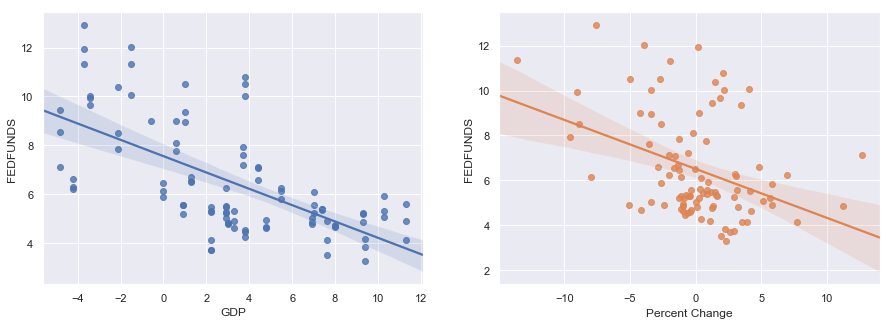

In [10]:
# Burns
df_combined_burns = df_combined[
    (df_combined['FDate'] >= '1970-01-01') &
    (df_combined['FDate'] < '1978-01-31')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined_burns, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined_burns, ax=ax2)
x = df_combined_burns['GDP']
y = df_combined_burns['FEDFUNDS']
linregress(x, y)
x = df_combined_burns['Percent Change']
y = df_combined_burns['FEDFUNDS']
linregress(x, y)
#df_combined_burns

#### Miller

LinregressResult(slope=-0.23984967777536903, intercept=10.064776832344652, rvalue=-0.7267162674261495, pvalue=0.0009515371860048844, stderr=0.058539095604044224)

LinregressResult(slope=-0.10185984895036353, intercept=9.356517454247012, rvalue=-0.26683192527927624, pvalue=0.3005285524471356, stderr=0.09499065471925602)

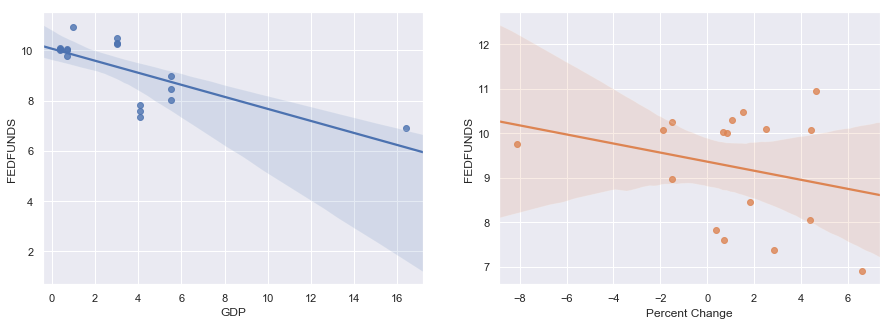

In [11]:
# Miller
df_combined_miller = df_combined[
    (df_combined['FDate'] >= '1978-03-08') &
    (df_combined['FDate'] < '1979-08-06')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined_miller, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined_miller, ax=ax2)
x = df_combined_miller['GDP']
y = df_combined_miller['FEDFUNDS']
linregress(x, y)
x = df_combined_miller['Percent Change']
y = df_combined_miller['FEDFUNDS']
linregress(x, y)

#### Volcker

LinregressResult(slope=-0.32623238379809627, intercept=11.599308580054645, rvalue=-0.3808550278324112, pvalue=0.000129167643862173, stderr=0.0816908975092789)

LinregressResult(slope=-0.34743033103051, intercept=11.041432940669653, rvalue=-0.3420076522744988, pvalue=0.0006483498603441242, stderr=0.09845910815059594)

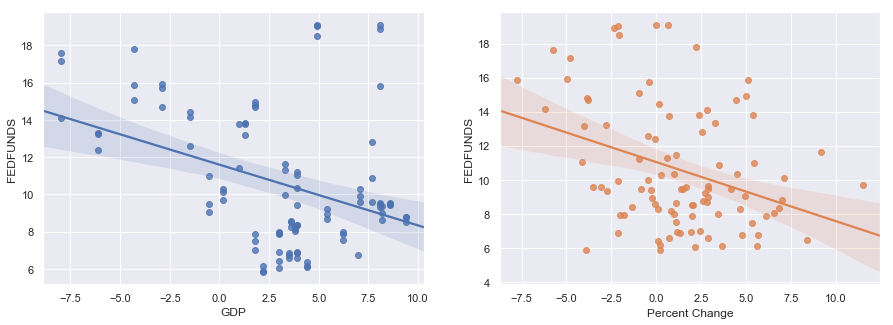

In [12]:
# Volcker
df_combined_volcker = df_combined[
    (df_combined['FDate'] >= '1979-08-06') &
    (df_combined['FDate'] < '1987-08-11')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined_volcker, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined_volcker, ax=ax2)
x = df_combined_volcker['GDP']
y = df_combined_volcker['FEDFUNDS']
linregress(x, y)
x = df_combined_volcker['Percent Change']
y = df_combined_volcker['FEDFUNDS']
linregress(x, y)

#### Greenspan

LinregressResult(slope=-0.1430792776272069, intercept=5.257756223978042, rvalue=-0.13604226272216535, pvalue=0.04334738837700227, stderr=0.07040837611687233)

LinregressResult(slope=0.03817783855371977, intercept=4.774741663018985, rvalue=0.05610897318967154, pvalue=0.40651402721989327, stderr=0.04590629610285619)

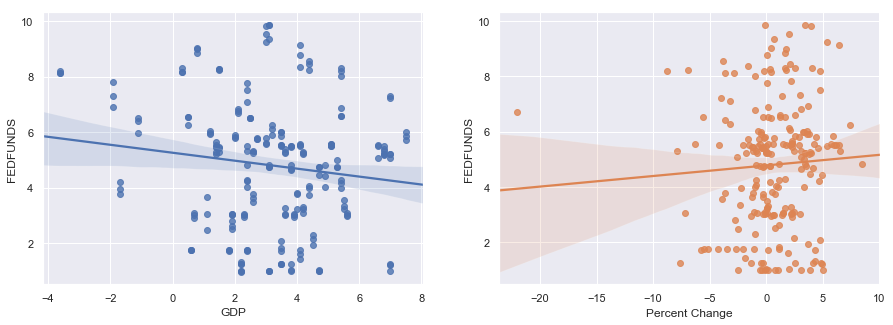

In [13]:
# Greenspan
df_combined_greenspan = df_combined[
    (df_combined['FDate'] >= '1987-08-11') &
    (df_combined['FDate'] <= '2006-01-31')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined_greenspan, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined_greenspan, ax=ax2)
x = df_combined_greenspan['GDP']
y = df_combined_greenspan['FEDFUNDS']
linregress(x, y)
x = df_combined_greenspan['Percent Change']
y = df_combined_greenspan['FEDFUNDS']
linregress(x, y)

#### Bernanke

LinregressResult(slope=-0.02541847949357692, intercept=1.5584564268580186, rvalue=-0.03256735244199413, pvalue=0.7527637902189401, stderr=0.08045865186689123)

LinregressResult(slope=-0.023977932586092886, intercept=1.5408888543463901, rvalue=-0.04089380478120259, pvalue=0.6924055116583159, stderr=0.06042641772314438)

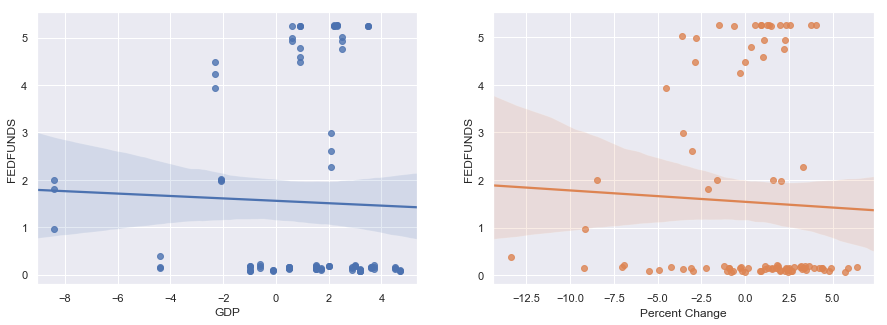

In [14]:
# Bernanke
df_combined_bernanke = df_combined[
    (df_combined['FDate'] >= '2006-02-01') &
    (df_combined['FDate'] <= '2014-01-31')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined_bernanke, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined_bernanke, ax=ax2)
x = df_combined_bernanke['GDP']
y = df_combined_bernanke['FEDFUNDS']
linregress(x, y)
x = df_combined_bernanke['Percent Change']
y = df_combined_bernanke['FEDFUNDS']
linregress(x, y)

#### Yellen

LinregressResult(slope=0.004110713219934354, intercept=0.4505537526111608, rvalue=0.011487301505754607, pvalue=0.9382329628490493, stderr=0.052758396510213704)

LinregressResult(slope=0.04262624065624464, intercept=0.42248923953040735, rvalue=0.211118353488135, pvalue=0.1497520806030881, stderr=0.029098549803500955)

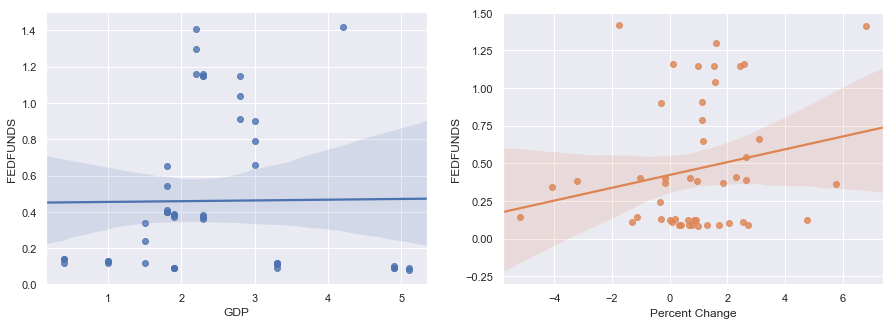

In [15]:
# Yellen
df_combined_yellen = df_combined[
    (df_combined['FDate'] >= '2014-02-03') &
    (df_combined['FDate'] <= '2018-02-03')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined_yellen, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined_yellen, ax=ax2)
x = df_combined_yellen['GDP']
y = df_combined_yellen['FEDFUNDS']
linregress(x, y)
x = df_combined_yellen['Percent Change']
y = df_combined_yellen['FEDFUNDS']
linregress(x, y)

#### Powell

LinregressResult(slope=-0.2602564102564102, intercept=2.693846153846154, rvalue=-0.8455251251383409, pvalue=0.00818071274310476, stderr=0.06709469758487724)

LinregressResult(slope=0.043741182727220156, intercept=1.8146275626249802, rvalue=0.38506429131050895, pvalue=0.3461988148865344, stderr=0.04279878823392776)

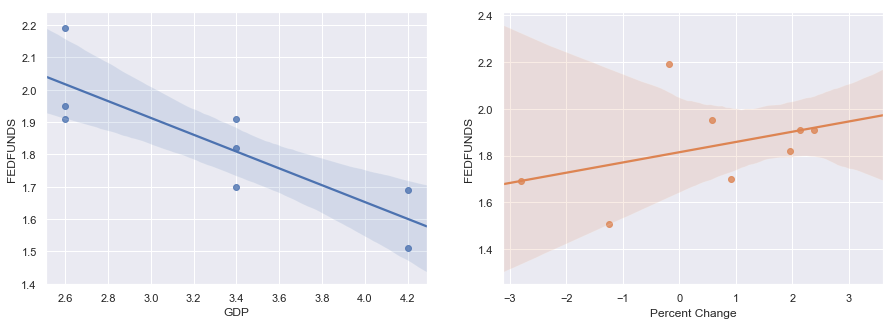

In [16]:
# Powell
df_combined_powell = df_combined[(df_combined['FDate'] >= '2018-02-05')]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.regplot(x='GDP', y='FEDFUNDS', data=df_combined_powell, ax=ax1)
ax2 = sns.regplot(x='Percent Change', y='FEDFUNDS', data=df_combined_powell, ax=ax2)
x = df_combined_powell['GDP']
y = df_combined_powell['FEDFUNDS']
linregress(x, y)
x = df_combined_powell['Percent Change']
y = df_combined_powell['FEDFUNDS']
linregress(x, y)

### Probabilities
We will calculate the probability of rate decrease the month after a stock market decrease, and the probability of rate decrease month after a GDP decrease.

#### Building dataframes

In [17]:
# Percent change in stock market vs rate action month after
fed_funds_plus1_df = pd.DataFrame.from_dict(df_combined.loc[1:, 'FEDFUNDS'])
fed_funds_plus1_df = fed_funds_plus1_df.reindex(range(0, len(fed_funds_plus1_df) - 1))
fed_funds_plus1_df = fed_funds_plus1_df.shift(-1)
percent_change_df = df_combined['Percent Change']
pc_fed_funds_plus1_df = fed_funds_plus1_df.join(percent_change_df)
pc_fed_funds_plus1_df['FEDFUNDS'] = pc_fed_funds_plus1_df['FEDFUNDS'].pct_change() * 100
pc_fed_funds_plus1_df.dropna(inplace=True)

#### Probability of rate decrease given stock market decline month prior

In [18]:
# # Iterate over dataframe and count occurences
countera = 0
counterb = 0
for i, row in pc_fed_funds_plus1_df.iterrows():
    if row['Percent Change'] < 0:
        counterb += 1
    if row['FEDFUNDS'] < 0 and row['Percent Change'] < 0:
        countera += 1
print("Conditional probability of rate decrease given S&P 500 decrease-")
countera / counterb


Conditional probability of rate decrease given S&P 500 decrease-


0.4083044982698962

#### Dataframes

In [19]:
# Dataframe work
gdp_fed_funds_plus1_df = fed_funds_plus1_df.join(df_combined['GDP'])
gdp_fed_funds_plus1_df['FEDFUNDS'] = gdp_fed_funds_plus1_df['FEDFUNDS'].pct_change() * 100
gdp_fed_funds_plus1_df.dropna(inplace=True)
gdp_fed_funds_plus1_df.drop(index=1, inplace=True)
gdp_fed_funds_plus1_slice_df = gdp_fed_funds_plus1_df[::3]



#### Probability of rate decrease given negative GDP growth month prior

In [20]:
# Iterate over dataframe and count occurences
countera = 0
counterb = 0
for i, row in gdp_fed_funds_plus1_slice_df.iterrows():
    if row['GDP'] < 0:
        counterb += 1
    if row['FEDFUNDS'] < 0 and row['GDP'] < 0:
        countera += 1
print("Conditional probability of rate decrease given GDP decrease-")
countera / counterb

Conditional probability of rate decrease given GDP decrease-


0.6666666666666666

## Conclusion
Historically, both GDP and S&P 500 are very slightly negatively correlated with the FFR. However, this trend flipped with Alan Greenspan's tenure as fed chairman. Since Greenspan, the FFR and the S&P 500 have a slightly positive correlation. This probably has something to do with Greenspan's rapid reduction in rates after the .com bubble popped, followed by stock market recovery as Greenspan slowly raised rates over the next decade. Every successive fed chair has maintained this positive correlation, while the negative correlation between GDP and FFR remains intact. 

Probability of rate decrease month after S&P 500 decline - 0.408

Probability of rate decrease month after GDP decline - 0.667

The Federal Reserve is *much* more likely to cut rates after a GDP decline than a stock market decline.

Initially, this project asked the question- "does the relationship between the FFR and the S&P 500 ever deviate from the relationship between the FFR and GDP?" The answer is most definitely yes, and it is part of a trend that started 20 years ago. Although it might not be an intuitive relationship, the trend of the last 20 years is that the stock market and FFR are positively correlated.

To be frank, I am not sure that my observation or the manner in which I analyzed the data is meaningless or not.